# Setup

## imports

In [1]:
import pickle
import os
import sys
import glob

In [2]:
import numpy
import librosa
import librosa.core
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense

Using TensorFlow backend.


## Macros

In [ ]:
pwd

In [17]:
FOLDER_ROOT = '../../'
DATA_FOLDER_RAW = 'raw'
#DATA_FOLDER_MONO = 'mono'
NOISE_L1_FN = 'noise_level_1_m6dB'
NOISE_L2_FN = 'noise_level_2_p0dB'
NOISE_L3_FN= 'noise_level_3_p6dB'
DEVICE_FNS = ['fan', 'valve', 'pump', 'slider']
DEVICE_ID_FNS = ['id_00', 'id_02', 'id_04', 'id_06']
DEVICE_COND_FNS = ['normal', 'abnormal']
LOGFILE = 'baseline.log'

#TODO picture save sceam

In [18]:
with open(FOLDER_ROOT + "setup_macro.yml") as stream:
        param = yaml.safe_load(stream)

param

### Setup Output Folders

In [21]:
os.makedirs(param["pickle_directory"], exist_ok=True)
os.makedirs(param["model_directory"], exist_ok=True)
os.makedirs(param["result_directory"], exist_ok=True)

### Setup input Folder

In [31]:
dirs = sorted(glob.glob(os.path.abspath( \
    "{base}/*/*/*".format(base=param["base_directory"].replace('./',FOLDER_ROOT))
    )))
dirs

['A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\fan\\id_00',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\fan\\id_02',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\fan\\id_04',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\fan\\id_06',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\pump\\id_00',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\pump\\id_02',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\pump\\id_04',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\pump\\id_06',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\slider\\id_00',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\slider\\id_02',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\slider\\id_04',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\slider\\id_06',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\valve\\id_00',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\valve\\id_02',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\valve\\id_04',
 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\0dB\\valve\\id_06',
 'A:\\Dev\\NF_Pr

In [30]:
param["base_directory"].replace('./',FOLDER_ROOT)

'../../dataset'

#### Check GPU supports

In [4]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


## Utility

In [33]:
logging.basicConfig(level=logging.DEBUG, filename=LOGFILE)
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

In [49]:
class visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss, val_loss):
        """
        Plot loss curve.

        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.

        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        ax.plot(val_loss)
        ax.set_title("Model loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Test"], loc="upper right")

    def save_figure(self, name):
        """
        Save figure.

        name : str
            save .png file path.

        return : None
        """
        self.plt.savefig(name)

In [34]:
def load_pickle(filename):
    """
    unpicklenize the data.

    filename : str
        pickle filename

    return : data
    """
    logger.info("load_pickle <- {}".format(filename))
    with open(filename, 'rb') as lf:
        load_data = pickle.load(lf)
    return load_data

In [35]:
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))

In [36]:
def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, numpy.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')

In [37]:
def file_to_vector_array(file_name,
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert file_name to a vector array.

    file_name : str
        target .wav file

    return : numpy.array( numpy.array( float ) )
        vector array
        * dataset.shape = (dataset_size, fearture_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(file_name)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # 03 convert melspectrogram to log mel energy
    log_mel_spectrogram = 20.0 / power * numpy.log10(mel_spectrogram + sys.float_info.epsilon)

    # 04 calculate total vector size
    vectorarray_size = len(log_mel_spectrogram[0, :]) - frames + 1

    # 05 skip too short clips
    if vectorarray_size < 1:
        return numpy.empty((0, dims), float)

    # 06 generate feature vectors by concatenating multi_frames
    vectorarray = numpy.zeros((vectorarray_size, dims), float)
    for t in range(frames):
        vectorarray[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vectorarray_size].T

    return vectorarray

In [38]:
def list_to_vector_array(file_list,
                         msg="calc...",
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0):
    """
    convert the file_list to a vector array.
    file_to_vector_array() is iterated, and the output vector array is concatenated.

    file_list : list [ str ]
        .wav filename list of dataset
    msg : str ( default = "calc..." )
        description for tqdm.
        this parameter will be input into "desc" param at tqdm.

    return : numpy.array( numpy.array( float ) )
        training dataset (when generate the validation data, this function is not used.)
        * dataset.shape = (total_dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 loop of file_to_vectorarray
    for idx in tqdm(range(len(file_list)), desc=msg):

        vector_array = file_to_vector_array(file_list[idx],
                                            n_mels=n_mels,
                                            frames=frames,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)

        if idx == 0:
            dataset = numpy.zeros((vector_array.shape[0] * len(file_list), dims), float)

        dataset[vector_array.shape[0] * idx: vector_array.shape[0] * (idx + 1), :] = vector_array

    return dataset

In [39]:
def dataset_generator(target_dir,
                      normal_dir_name="normal",
                      abnormal_dir_name="abnormal",
                      ext="wav"):
    """
    target_dir : str
        base directory path of the dataset
    normal_dir_name : str (default="normal")
        directory name the normal data located in
    abnormal_dir_name : str (default="abnormal")
        directory name the abnormal data located in
    ext : str (default="wav")
        filename extension of audio files 

    return : 
        train_data : numpy.array( numpy.array( float ) )
            training dataset
            * dataset.shape = (total_dataset_size, feature_vector_length)
        train_files : list [ str ]
            file list for training
        train_labels : list [ boolean ] 
            label info. list for training
            * normal/abnormal = 0/1
        eval_files : list [ str ]
            file list for evaluation
        eval_labels : list [ boolean ] 
            label info. list for evaluation
            * normal/abnormal = 0/1
    """
    logger.info("target_dir : {}".format(target_dir))

    # 01 normal list generate
    normal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                 normal_dir_name=normal_dir_name,
                                                                 ext=ext))))
    normal_labels = numpy.zeros(len(normal_files))
    if len(normal_files) == 0:
        logger.exception("no_wav_data!!")

    # 02 abnormal list generate
    abnormal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{abnormal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                   abnormal_dir_name=abnormal_dir_name,
                                                                   ext=ext))))
    abnormal_labels = numpy.ones(len(abnormal_files))
    if len(abnormal_files) == 0:
        logger.exception("no_wav_data!!")

    # 03 separate train & eval
    train_files = normal_files[len(abnormal_files):]
    train_labels = normal_labels[len(abnormal_files):]
    eval_files = numpy.concatenate((normal_files[:len(abnormal_files)], abnormal_files), axis=0)
    eval_labels = numpy.concatenate((normal_labels[:len(abnormal_files)], abnormal_labels), axis=0)
    logger.info("train_file num : {num}".format(num=len(train_files)))
    logger.info("eval_file  num : {num}".format(num=len(eval_files)))

    return train_files, train_labels, eval_files, eval_labels

# Keras MODEL 

In [40]:
def keras_model(inputDim):
    """
    define the keras model
    the model based on the simple dense auto encoder (64*64*8*64*64)
    """
    inputLayer = Input(shape=(inputDim,))
    h = Dense(64, activation="relu")(inputLayer)
    h = Dense(64, activation="relu")(h)
    h = Dense(8, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(64, activation="relu")(h)
    h = Dense(inputDim, activation=None)(h)

    return Model(inputs=inputLayer, outputs=h)

In [ ]:
# Train 

In [46]:
# generate files
target_dir = 'A:\\Dev\\NF_Prj_MIMII_Dataset\\dataset\\min6dB\\pump\\id_00'
train_files, train_labels, eval_files, eval_labels = dataset_generator(target_dir)

2020-04-13 16:11:37,894 - INFO - target_dir : A:\Dev\NF_Prj_MIMII_Dataset\dataset\min6dB\pump\id_00
2020-04-13 16:11:37,894 - INFO - target_dir : A:\Dev\NF_Prj_MIMII_Dataset\dataset\min6dB\pump\id_00
2020-04-13 16:11:37,902 - INFO - train_file num : 863
2020-04-13 16:11:37,902 - INFO - train_file num : 863
2020-04-13 16:11:37,903 - INFO - eval_file  num : 286
2020-04-13 16:11:37,903 - INFO - eval_file  num : 286


In [47]:
eval_labels, train_labels # intention that all train lables are 0 ( seems a auto encoder thing)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 

In [48]:
# prep data ( embedding)
train_data = list_to_vector_array(train_files,
                                              msg="generate train_dataset",
                                              n_mels=param["feature"]["n_mels"],
                                              frames=param["feature"]["frames"],
                                              n_fft=param["feature"]["n_fft"],
                                              hop_length=param["feature"]["hop_length"],
                                              power=param["feature"]["power"])

generate train_dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 863/863 [02:43<00:00,  5.28it/s]


In [51]:
model = keras_model(param["feature"]["n_mels"] * param["feature"]["frames"])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20544     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 320)               2080

In [52]:
model.compile(**param["fit"]["compile"])

In [54]:
history = model.fit(train_data,
                    train_data,
                    epochs=param["fit"]["epochs"],                        batch_size=param["fit"]["batch_size"],
                    shuffle=param["fit"]["shuffle"],
                    validation_split=param["fit"]["validation_split"],
                    verbose=param["fit"]["verbose"])

Train on 240000 samples, validate on 26667 samples
Epoch 1/50
240000/240000 [==============================] - 4s 15us/step - loss: 41.2684 - val_loss: 12.5723
Epoch 2/50
240000/240000 [==============================] - 3s 12us/step - loss: 11.7465 - val_loss: 10.8036
Epoch 3/50
240000/240000 [==============================] - 3s 12us/step - loss: 10.4883 - val_loss: 10.2239
Epoch 4/50
240000/240000 [==============================] - 3s 12us/step - loss: 10.0793 - val_loss: 9.9327
Epoch 5/50
240000/240000 [==============================] - 3s 12us/step - loss: 9.9046 - val_loss: 9.8747
Epoch 6/50
240000/240000 [==============================] - 3s 12us/step - loss: 9.8191 - val_loss: 9.7274
Epoch 7/50
240000/240000 [==============================] - 3s 12us/step - loss: 9.7196 - val_loss: 9.6242
Epoch 8/50
240000/240000 [==============================] - 3s 12us/step - loss: 9.6271 - val_loss: 9.5814
Epoch 9/50
240000/240000 [==============================] - 3s 13us/step - loss: 9.545

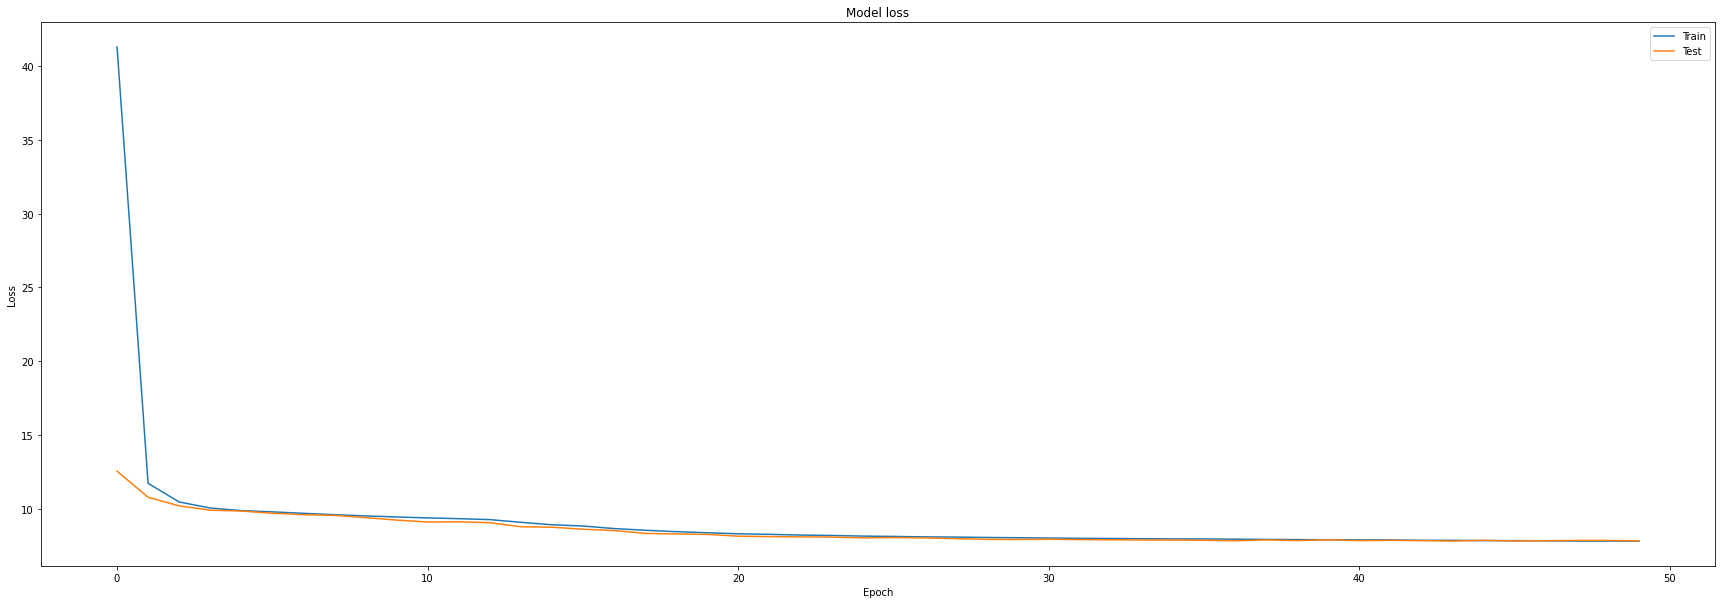

In [55]:
visualizer = visualizer()
visualizer.loss_plot(history.history["loss"], history.history["val_loss"])

## EVAL

In [63]:
y_pred = [0. for k in eval_labels]
y_true = eval_labels
evaluation_result = {}
results = {}
evaluation_result_key = 'min6dB_pump_id00'

SyntaxError: invalid syntax (<ipython-input-63-c32eed453aae>, line 5)

In [61]:

for num, file_name in tqdm(enumerate(eval_files), total=len(eval_files)):
    try:
        data = file_to_vector_array(file_name,
                                    n_mels=param["feature"]["n_mels"],
                                    frames=param["feature"]["frames"],
                                    n_fft=param["feature"]["n_fft"],
                                    hop_length=param["feature"]["hop_length"],
                                    power=param["feature"]["power"])
        error = numpy.mean(numpy.square(data - model.predict(data)), axis=1)
        y_pred[num] = numpy.mean(error)
    except:
        logger.warning("File broken!!: {}".format(file_name))



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 286/286 [00:50<00:00,  5.70it/s]


In [64]:
evaluation_result_key = 'min6dB_pump_id00'
score = metrics.roc_auc_score(y_true, y_pred)
logger.info("AUC : {}".format(score))
evaluation_result["AUC"] = float(score)
results[evaluation_result_key] = evaluation_result
print("===========================")

2020-04-13 16:33:09,972 - INFO - AUC : 0.5900533033400166
2020-04-13 16:33:09,972 - INFO - AUC : 0.5900533033400166


In [65]:
result_file = "{result}/{file_name}".format(result=param["result_directory"], file_name=param["result_file"])


In [66]:
print("\n===========================")
logger.info("all results -> {}".format(result_file))
with open(result_file, "w") as f:
    f.write(yaml.dump(results, default_flow_style=False))
print("===========================")

2020-04-13 16:33:16,583 - INFO - all results -> ./result/result.yml
2020-04-13 16:33:16,583 - INFO - all results -> ./result/result.yml
